# Assignment 1: Heart Failure Classification Problem
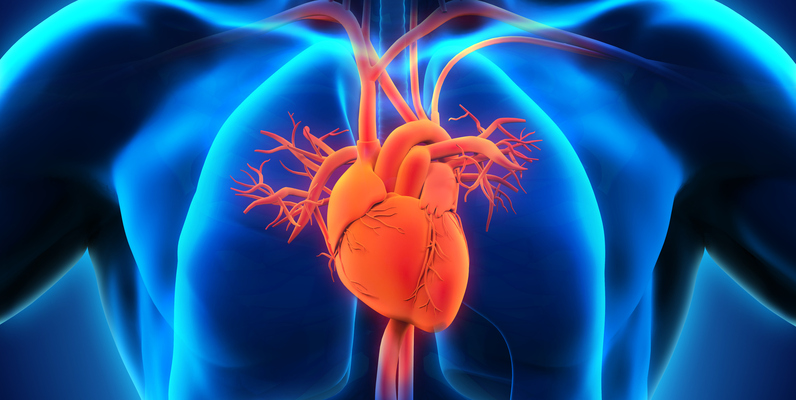

##### **Team Members**

- **Rawan Mohamed Said** - 21010547
- **Yomna Yasser Sobhy Zaki** - 21011566  
- **Omnia Tarek Ibrahim** - 21010298


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

## **Helper Functions**

In [2]:
def plot_confusion_matrix(y_test, y_predict, color='Blues'):
  cm = confusion_matrix(y_test, y_predict)
  plt.figure(figsize=(5, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap=color)
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix")
  plt.show()

## **Dataset and Preparation**





After downloading the dataset, Read it from the .csv file and start getting familiar the dataset.

In [3]:
df = pd.read_csv("./heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
df.shape

(918, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


### Fixed Random Seed
Set the seed which is considered as an intial value for the pesudo random generator to get the same sequence of random values each time/run and ensure reproducibility across experiement.

In [6]:
RANDOM_SEED = 42

### Feature Preprocessing:

In [7]:
# divide data into features and target/actual class
x = df.drop(['HeartDisease'], axis=1)
y = df["HeartDisease"]

#### Categorical Features Encoding

We need to convert categorical variables into numeric as many machine learning models can handle numeric variables only.
There are many ways to do that e.g. one-hot encoding and label encoding
the main differance between them that one-hot encoding adds column for each category and its values are zero or one.
For the label encoding it gives each category a value (0, 1, 2,...) in the same column and that could introduce problems. The model could thing that there are relation between these category like the category with value 1 is larger than value 0. In other words, It may introduce order for the categories so its better to use it when the data has natural order.


In [8]:
# get all categorical columns
categorical_cols = x.select_dtypes(include=['object']).columns.tolist()

# use OneHotEncoder to convert categorical variable into binary format
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(x[categorical_cols])
one_hot_x = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_cols))
x = pd.concat([x, one_hot_x], axis=1)
x = x.drop(categorical_cols, axis=1)

In [9]:
x.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,49,160,180,0,156,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37,130,283,0,98,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,48,138,214,0,108,1.5,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,54,150,195,0,122,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


#### Data Scaling

We need to standardize or normalize the data.
  * Normalization => (x - min) / ( max - min)
  * Standarization => (x - mean) / sd

For our dataset, It's better to use **standarization** because of the outliers that our dataset has. Standardization ensures that the data is centered around 0 with a standard deviation of 1, and it is less sensitive to outliers compared to normalization.

**NOTE**: Scaling is important for distance-based algorithms such as **k Nearest Neighbors** because when the features have different scales:
* The algorithm prioritizes features with larger scales, even if those features are less relevant.
* Features on smaller scales contribute almost nothing to the distance metric, effectively making them irrelevant.

and it is also important for **Neural Network** to improve the stability of weight updates which helps the gradient decent converge faster.

However, **Decision Trees** are insensitive to the scale of the dataset because of its structure.

<Axes: >

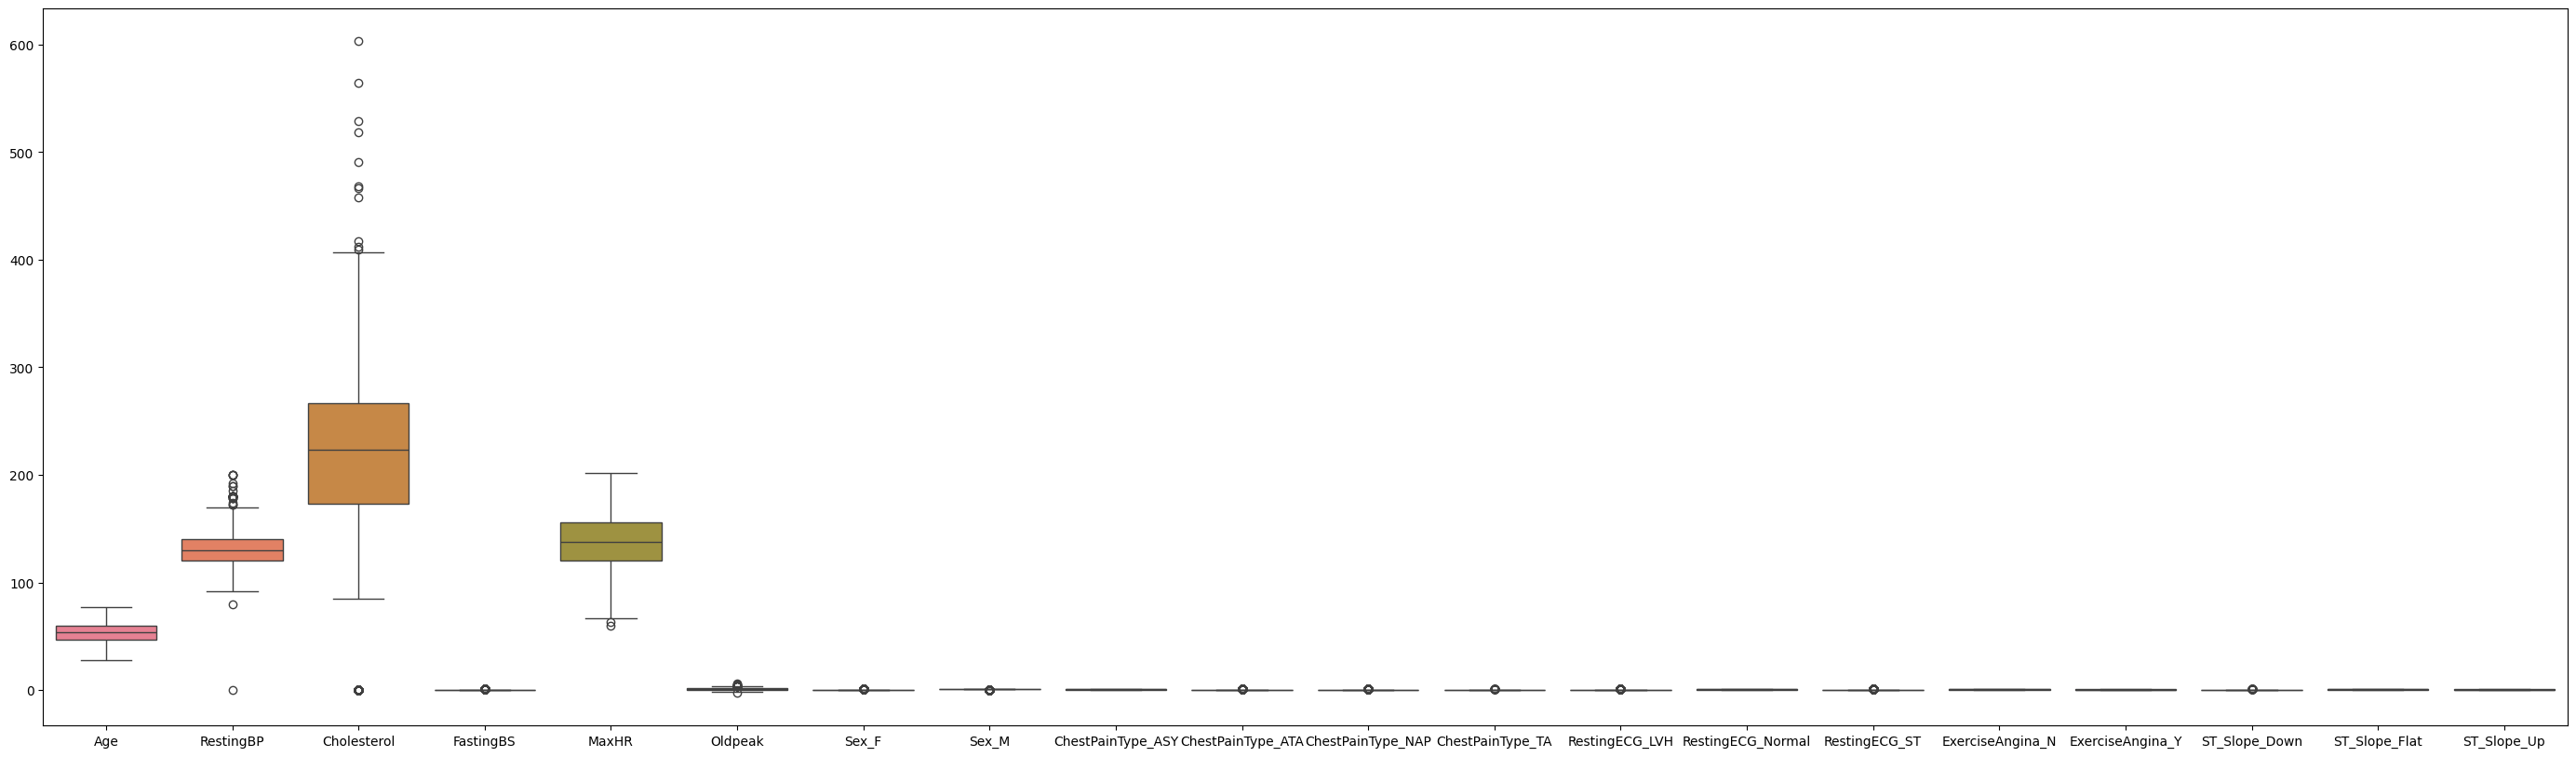

In [10]:
# use box plot to show the scales of each feature and observe the outliers.
plt.figure(figsize=(35,10))
sns.boxplot(data=x)

In [11]:
# apply standardization
scaler = StandardScaler()
scaled_x = scaler.fit_transform(x)
x = pd.DataFrame(scaled_x, columns=x.columns)

<Axes: >

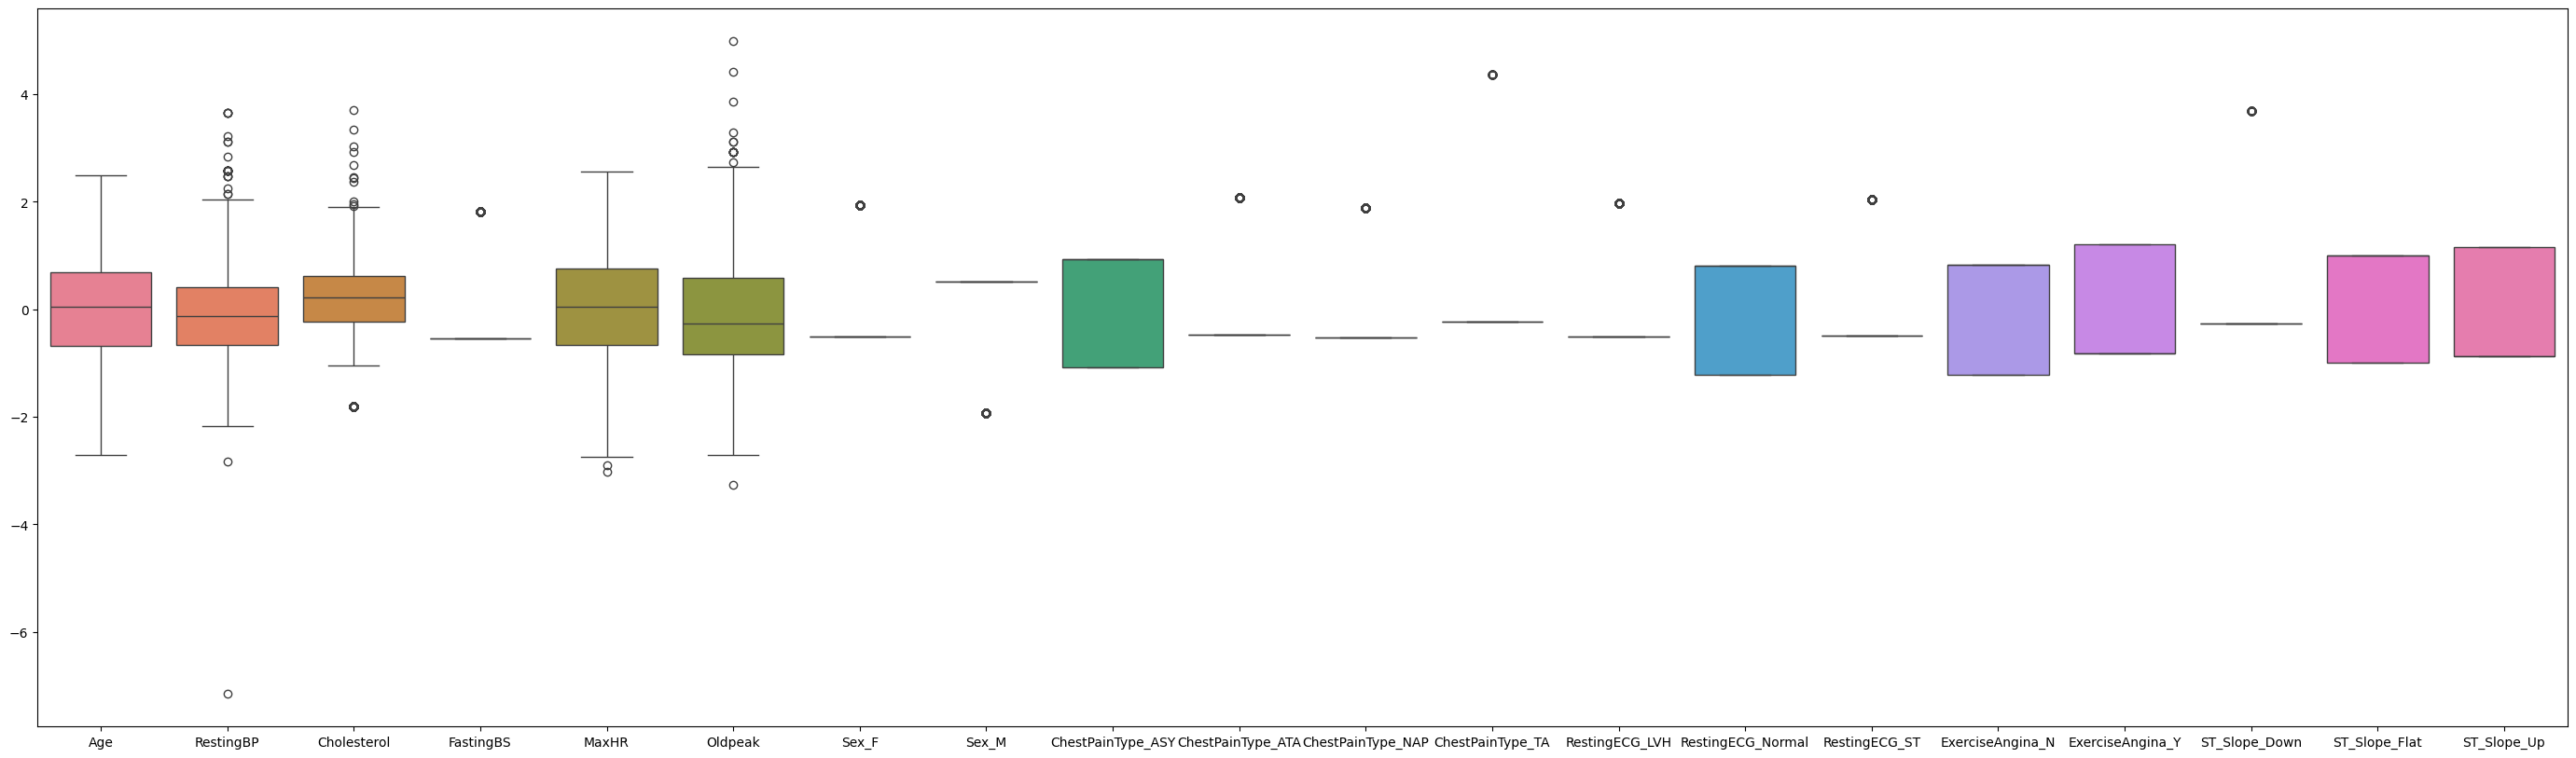

In [12]:
# use box plot after to show the effect of the standardization
plt.figure(figsize=(35,10))
sns.boxplot(data=x)

### Train/Validation/Test Split

Splitting the data into train, validation and test sets and use stratify to ensure that the propotion of each class is same as its propotion in the original dataset.

In [13]:
# split data into train_validation and test where the size of the test = 0.2
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, random_state=RANDOM_SEED, test_size=0.2, stratify=y)

# split train_validation into train and validation where the size of the validation = 1/8 = 0.125
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, random_state=RANDOM_SEED, test_size = 0.125, stratify=y_train_val)

In [14]:
print(f"Train size: {x_train.shape[0]}, Validation size: {x_val.shape[0]}, Test size: {x_test.shape[0]}")

Train size: 642, Validation size: 92, Test size: 184


## Decision Tree

In [15]:
from decision_tree import DecisionTree

In [16]:
# Training and validating the model to tune the parameters (max depth and min samples split)
tree = DecisionTree()
tree.auto_tune(x_train, y_train, x_val, y_val)
tree.fit(x_train, y_train)

Best parameters: max_depth=6, min_samples_split=11


In [17]:
# Validation accuracy
dec_y_val_pred = tree.predict(x_val)
dec_val_accuracy = accuracy_score(y_val, dec_y_val_pred)
print(f"Validation Accuracy: {dec_val_accuracy:.4f}")

Validation Accuracy: 0.8261


### Evaluation

In [18]:
# Testing the model
dec_y_test_pred = tree.predict(x_test)
dec_test_accuracy = accuracy_score(y_test, dec_y_test_pred)
dec_test_f1 = f1_score(y_test, dec_y_test_pred, average="weighted")

print(classification_report(y_test, dec_y_test_pred))

              precision    recall  f1-score   support

           0       0.73      0.78      0.75        82
           1       0.81      0.76      0.79       102

    accuracy                           0.77       184
   macro avg       0.77      0.77      0.77       184
weighted avg       0.77      0.77      0.77       184



In [19]:
results_df = pd.DataFrame({
    "Model": ["Decision Tree"],
    "   Validation Accuracy": [dec_val_accuracy],
    "   Test Accuracy": [dec_test_accuracy],
    "   Test F1-Score": [dec_test_f1]
})
print("Performance Summary:\n", results_df)

Performance Summary:
            Model     Validation Accuracy     Test Accuracy     Test F1-Score
0  Decision Tree                0.826087          0.771739          0.772309


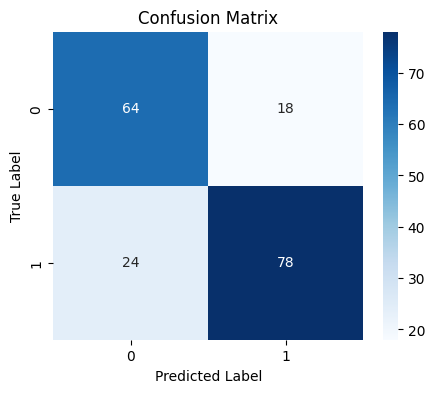

In [20]:
# Confusion Matrix
plot_confusion_matrix(y_test, dec_y_test_pred)

In [22]:
# Finding the Most Confusing Classes
cm = confusion_matrix(y_test, dec_y_test_pred)
np.fill_diagonal(cm, 0)
most_confused_idx = np.unravel_index(np.argmax(cm), cm.shape)
print(f"Most Confused Class -> Predicted = {most_confused_idx[1]}, True = {most_confused_idx[0]} with {cm[most_confused_idx]} misclassifications")

Most Confused Class -> Predicted = 0, True = 1 with 24 misclassifications


## Bagging Ensemble

## Ada Boost Ensemble

In [ ]:
# AdaBoost

# stump for the iteration to decide which to split on.
# calculate error
# calculating alpha
# calculate new weights
# the final H(x)



i want to return from best split the feature index, the threshold, the sides classification, error, left, right of it so i can then calculate new weights

In [23]:
## This function is to find best split
import numpy as np

def find_best_split(X, y, sample_weights):
    n_samples, n_features = X.shape
    best_feature_index, best_threshold, best_error, best_less_or_equal_classification = None, None, float('inf'), None

    for feature_index in range(n_features):
        sorted_values = np.sort(np.unique(X[:, feature_index]))  # Sort unique values
        thresholds = (sorted_values[:-1] + sorted_values[1:]) / 2  # Compute midpoints which helps in case of continuous values

        for threshold in thresholds:
            # Compute weight sums for each class split
            X = np.array(X)
            y = np.array(y)
            sample_weights = np.array(sample_weights)
            # Compute weight sums for each class split
            left_weights_positive = np.sum(sample_weights[(X[:, feature_index] <= threshold) & (y == 1)])     # for left samples with positive label
            left_weights_negative = np.sum(sample_weights[(X[:, feature_index] <= threshold) & (y == -1)])    # for left samples with negative label
            right_weights_positive = np.sum(sample_weights[(X[:, feature_index] > threshold) & (y == 1)])     # for right samples with positive label
            right_weights_negative = np.sum(sample_weights[(X[:, feature_index] > threshold) & (y == -1)])    # for right samples with negative label

            # Determine best class assignment
            if (left_weights_negative + right_weights_positive) <= (left_weights_positive + right_weights_negative):
                split_best_less_or_equal_classification = 1
                misclassified_weight = left_weights_negative + right_weights_positive
            else:
                split_best_less_or_equal_classification = -1
                misclassified_weight = left_weights_positive + right_weights_negative

            # Update best split if found a lower error
            if misclassified_weight < best_error:
                best_feature_index = feature_index
                best_threshold = threshold
                best_error = misclassified_weight
                best_less_or_equal_classification = split_best_less_or_equal_classification

    return best_feature_index, best_threshold, best_error, best_less_or_equal_classification

In [24]:
# calculating the new alpha (classifier coefficient)
def calculate_alpha(error):
    return 0.5 * np.log((1 - error) / error)

In [25]:
# calculating new weights for each sample
def calculate_new_weights(weights, error, is_right_classified):
    new_weights = []

    for i in range(len(is_right_classified)):
        if is_right_classified[i] == 1:
            new_weights.append((0.5 * weights[i]) / (1 - error))
        else:
            new_weights.append((0.5 * weights[i]) / error)
    return new_weights

In [26]:
# AdaBoost Classifier
class AdaBoostClassifier:
    def __init__(self, n_estimators=50):
        self.n_estimators = n_estimators
        self.models = []
    def fit(self, X, y_binary):
        n_samples, n_features = X.shape
        weights = np.full(n_samples, 1 / n_samples)
       ## iam just using another column y
        y = np.where(y_binary == 0, -1, 1) ## it is faster than looping as it is vectorized
        for _ in range(self.n_estimators):
            feature_index, threshold, error, less_or_equal_classification = find_best_split(X, y, weights)
            is_right_classified = np.where(((X[:, feature_index] <= threshold) & (y == less_or_equal_classification)) |
                      ((X[:, feature_index] > threshold) & (y == -less_or_equal_classification)), 1, -1)
            error = max(error, 1e-10) # to avoid divisions by zero
            weights = calculate_new_weights(weights, error, is_right_classified)
            alpha = calculate_alpha(error)
            model = (feature_index, threshold, alpha, less_or_equal_classification)
            self.models.append(model)


   # for predicting a set of samples
    def predict(self, X):
        n_samples = X.shape[0]
        y_pred = np.zeros(n_samples)  # Initialize predictions to zero

        for feature_index, threshold, alpha, less_or_equal_classification in self.models:
            # Create predictions for this weak learner for all X sample i gave to it
            y_pred_i = np.where(X[:, feature_index] <= threshold, less_or_equal_classification, -less_or_equal_classification)
            # Accumulate the weighted predictions
            y_pred += alpha * y_pred_i
        return np.sign(y_pred)  # Final prediction: sign of weighted sum


In [27]:
AdaBoost = AdaBoostClassifier(n_estimators=50)
AdaBoost.fit(x_train.to_numpy(), y_train.to_numpy())
y_predict = AdaBoost.predict(x_test.to_numpy())
y_test_normalized = np.where(y_test == 0, -1, 1) ## it is faster than looping as it is vectorized
misclassified = np.sum(y_predict != y_test_normalized)  # Count misclassified samples
error_rate = misclassified / len(y_test)  # Compute error rate
print(error_rate)

0.11413043478260869


In [28]:
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.tree import DecisionTreeClassifier
# import numpy as np
# from sklearn.metrics import classification_report

# # Create AdaBoost with weak classifiers (Decision Trees)
# ada = AdaBoostClassifier(
#     estimator=DecisionTreeClassifier(max_depth=1),
#     n_estimators=10,
#     learning_rate=0.5
# )

# # Train AdaBoost
# ada.fit(x_train.to_numpy(), y_train.to_numpy())

# # Predict on test set
# y_pred = ada.predict(x_test.to_numpy())

# # Compute error rate
# misclassified = np.sum(y_pred != y_test.to_numpy())
# error_rate = misclassified / len(y_test)
# print(f"Error Rate: {error_rate:.4f}")


## **Bonus**

### Logistic Regression

In [29]:
logistic_model= LogisticRegression(random_state = RANDOM_SEED, max_iter = 100)
logistic_model.fit(x_train_val,y_train_val)


LogisticRegression(random_state=42)

In [30]:
y_test_pred = logistic_model.predict(x_test)


Logistic Regression Accuracy is 0.8858695652173914


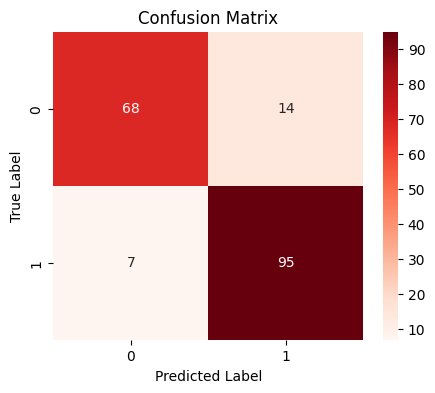

In [31]:
accuracy = accuracy_score(y_test, y_test_pred)
print( f'Logistic Regression Accuracy is {accuracy}')

plot_confusion_matrix(y_test, y_test_pred, "Reds")

### Feedforward Neural Network (FNN)

In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

In [33]:
# Making a Simple Feedforward Neural Network
model = Sequential([
    Input(shape=(x_train.shape[1],)),           # Input layer with shape of the input data
    Dense(32, activation='relu'),               # Hidden layer with 32 neurons with ReLU activation
    Dense(1, activation='sigmoid')              # Output layer (Binary Classification) with Sigmoid activation
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [34]:
# Training the model with 50 epochs and batch size of 16
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=16, verbose=1)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8255 - loss: 0.4193 - val_accuracy: 0.8370 - val_loss: 0.3988
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8495 - loss: 0.3487 - val_accuracy: 0.7935 - val_loss: 0.3843
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8820 - loss: 0.3008 - val_accuracy: 0.8261 - val_loss: 0.3869
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8793 - loss: 0.2591 - val_accuracy: 0.8696 - val_loss: 0.3408
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8810 - loss: 0.2956 - val_accuracy: 0.8587 - val_loss: 0.3428
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8897 - loss: 0.2781 - val_accuracy: 0.8370 - val_loss: 0.3774
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9041 - loss: 0.2696 - val_accuracy: 0.8587 - val_loss: 0.3368
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8918 - loss: 0.2630 - val_accuracy: 0.8478 - val_loss:

In [36]:
# Evaluating the model on the test set
fnn_test_loss, fnn_test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {fnn_test_accuracy:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8914 - loss: 0.7447 
Test Accuracy: 0.8750


In [37]:
fnn_y_test_pred = (model.predict(x_test) > 0.5).astype(int) # Convert probabilities to binary predictions
print("Classification Report:\n", classification_report(y_test, fnn_y_test_pred))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.87        82
           1       0.92      0.85      0.88       102

    accuracy                           0.88       184
   macro avg       0.87      0.88      0.87       184
weighted avg       0.88      0.88      0.88       184



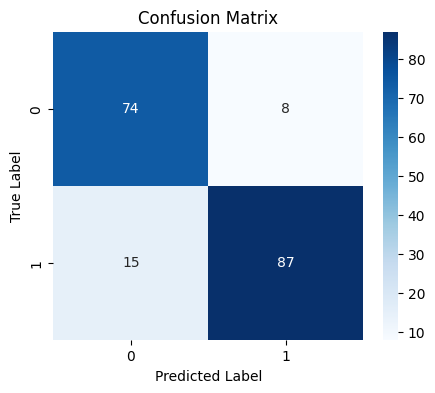

In [38]:
plot_confusion_matrix(y_test, fnn_y_test_pred)